## Simulation of 2D mail delivery system with Monte Carlo

In [1]:
import Pkg;
Pkg.add("Plots")
Pkg.add("Statistics")
Pkg.add("StatsBase")
Pkg.add("WebIO")
Pkg.add("DelimitedFiles") 
Pkg.add("PyPlot") #on-the-fly animation using pyplot backend seems less flickers
Pkg.build("PyCall")

In [2]:
using Plots, Statistics,Random, StatsBase, DelimitedFiles

## Rules and policy

<img src='cmap.gif' width="400" height="300">

In this subject, we consider a mail delivery system where mails are delivered on a network of connected stations,  
and they can only be delivered from station to station, say via mail service workers on horses.   
It starts at $0$ (the source), with two types of mails (A and B. It can be more than two types in a more complicated setup).   
Stations $3$(B) and $6$(A) are the respective destinations. After going to the correct destination, the mails are sent to $7$ (the drain).  
Here a few basic rules for delivery the mails:  
- For each time step, the mails move only one step.
- One station can have at most one mail at each time step.
- The mail is allowed to be delivered to any of the available connected stations.
- The probabilities of going to any station is user-defined



## Core functions for delivery algorithm



The connectivity matrix describes all connections of the stations to one another.  
We indicate 1 in the corresponding row and columns to indicate a connection.  
For eg. where 1 connects to 2, the matrix (row,column)->(1,2)=1  
At this stage, this is manually input.  
The connectivity matrix describing the above node connections that **allows for all directions** is as follows:


### 1. Connectivity matrix for the delivery path (tested)


In [41]:
# connectivity matrix
# Vetically, the mail can be delivered back; Horizontally, the mail can only be delivered forward to the destination.
function connect_matrix_2D()
    #1st row is source, last row is drain. all entries are connected to source, all exits are connected to drain!
    C = zeros(Float64,8,8);
    C[1,2] = 1;
    
    C[2,3] = 1;
    C[2,5] = 1;
    
    C[3,2] = 1;
    C[3,4] = 1;
    C[3,6] = 1;
    
    C[4,3] = 1;
    C[4,8] = 1;
    
    C[5,2] = 1;
    C[5,6] = 1;
    
    C[6,3] = 1;
    C[6,5] = 1;
    C[6,7] = 1;
    
    C[7,6] = 1; 
    C[7,8] = 1;
    
    C[8,8] = 1;
    return C
end


connect_matrix_2D (generic function with 1 method)

In [4]:
function connect_matrix_A()
    A = zeros(Float64,8,8);
    A[1,2] = 1;
    
    A[2,3] = 0.1;
    A[2,5] = 0.9;
    
    A[3,2] = 0.1;
    A[3,4] = 0.1;
    A[3,6] = 0.8;
    
    A[4,3] = 1; #if A mail reaches B(3), mail returns to station 2 with 100% probability.
    
    A[5,2] = 0.1;
    A[5,6] = 0.9;
    
    A[6,3] = 0.1;
    A[6,5] = 0.1;
    A[6,7] = 0.8;
    
    A[7,8] = 1; 
 
    return A
end


connect_matrix_A (generic function with 1 method)

In [40]:
function connect_matrix_B()
    B = zeros(Float64,8,8);
    B[1,2] = 1;
    
    B[2,3] = 0.9;
    B[2,5] = 0.1;
    
    B[3,2] = 0.1;
    B[3,4] = 0.8;
    B[3,6] = 0.1;
    
    B[4,8] = 1;
        
    B[5,2] = 0.9;
    B[5,6] = 0.1;
    
    B[6,3] = 0.8;
    B[6,5] = 0.1;
    B[6,7] = 0.1;
     
    B[7,6] = 1; #if B mail reaches A(6), mail returns to station 5 with 100% probability.  
 
    return B
end

connect_matrix_B (generic function with 1 method)

In [6]:
C = connect_matrix_2D()

8×8 Matrix{Float64}:
 0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  1.0  0.0  1.0  0.0  0.0  0.0
 0.0  1.0  0.0  1.0  0.0  1.0  0.0  0.0
 0.0  0.0  1.0  0.0  0.0  0.0  0.0  1.0
 0.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0
 0.0  0.0  1.0  0.0  1.0  0.0  1.0  0.0
 0.0  0.0  0.0  0.0  0.0  1.0  0.0  1.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0

In [7]:
conn_matA = connect_matrix_A()

8×8 Matrix{Float64}:
 0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.5  0.0  0.5  0.0  0.0  0.0
 0.0  0.2  0.0  0.2  0.0  0.6  0.0  0.0
 0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.3  0.0  0.0  0.0  0.7  0.0  0.0
 0.0  0.0  0.2  0.0  0.2  0.0  0.6  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0

In [8]:
conn_matB = connect_matrix_B()

8×8 Matrix{Float64}:
 0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.5  0.0  0.5  0.0  0.0  0.0
 0.0  0.3  0.0  0.6  0.0  0.1  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0
 0.0  0.5  0.0  0.0  0.0  0.5  0.0  0.0
 0.0  0.0  0.6  0.0  0.2  0.0  0.2  0.0
 0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0

# Allows for freeplay of probability distributions
## - distance weighted probabilities
## - competition - A optimises correct deliveries, B proportionately optimises preventing A from correct deliveries while having correct deliveries

### 2. Function that initializes the matrix of histories (tested)
Entries of history matrix, $H$, are initialized to 0.  
All mails get ready at position 1.  
This matrix stores the trajectory of the mails across time.  
Each **row** corresponds to a mail in the system and each **column** stores the positions of all the mails at a snapshot in time.  
Going across the row tells you the position of a particular mail across time.

In [9]:
function initialize_H(NC,tM)
    # tM maximum number of time steps
    # NC is the number of mails
    return H = zeros(Int16,NC, tM+2); #this tM+2 can be alterd to taste    
end

initialize_H (generic function with 1 method)

### 3. Function that finds available next positions (tested)
Given a mail's position (for example, ip), the following procedures are used to determine the available positions
- Determine the **reachable positions** by inspecting the corresponding row of the connectivity matrix, $C$
- Determine the **occupied positions** by inspecting the column of history matrix, $H$, corresponds to the time step.  
However, $0$, $L+1$ are excluded.  
Recall the position $0$ is the source which hosts the awaiting of mails, and $L+1$ is for the drain of mails, respectively. 
- **Positions available** are the positions which are reachable but not occupied. Equivalently, set of reachable subtract set of occupied.

In [10]:
function find_pos_available_k(ic,it,H,C,L,conn_mat) 
    # ic is the mail number 
    # it is the time step 
    # H matrix of histories 
    # C connectivity matrix 
    # L is the number of stations 
    # for a particular mail at a particular time, 
    aux = size(H);
    NC = copy(aux[1]); #NC returns the total number of mails 
    vec_pos0 = Int64.(zeros(0)); 
    vec_pos = Int64.(zeros(0)); 
    vec_prob0 = Float64.(zeros(0)); 
    vec_prob = Float64.(zeros(0)); 
    
    ip = copy(H[ic,it]); #obtain current position of the mail from history matrix    
    for iL = 1:L+2 #check all possible positions, +2 to account for source and drain
        if C[ip+1,iL] == 1 #(row,col) check whether this station is connected to station ip (it would be a 1 in the connectivity matrix)
                           #ip+1 to account for numbering of station, 0th station starts at 1st row. 
            if conn_mat[ip+1,iL] != 0 #check whether mail type has prob of moving to station iL, if so, store position and corresponding probability
                vec_pos0 = append!(vec_pos0, iL-1); #stores all reachable stations
                vec_prob0 = append!(vec_prob0, conn_mat[ip+1,iL]); #store prob of respective reachable stations
            end
        end
    end
    
    #conflict resolution
    aux = size(vec_pos0) #total number of reachable stations
    for ipos = 1:aux[1] #going across all possible stations
        s=0;
        if (vec_pos0[ipos] != L+1)  #if the mail is not outside, which is at L+1   
            for iNC = 1:NC #going across all mails
                if H[iNC,it] == copy(vec_pos0[ipos]); #checks if stations is already occupied by other mails. if so, add 1 to s. 
                    s+=1;
                end
            end
        end    
        if s==0 #if s!=1, proceed
            vec_pos = append!(vec_pos,vec_pos0[ipos]); # if there are no collisions, store particular reachable station in vec_pos which is returned by this function.
            vec_prob = append!(vec_prob,vec_prob0[ipos]);
            
        end
    end
        if !isempty(vec_prob) #if probability vector is not empty, normalise it
            vec_prob = vec_prob./sum(vec_prob);#normalise probability here!
        end
    return vec_pos, vec_prob
end

find_pos_available_k (generic function with 1 method)

In [11]:
H = initialize_H(4,10)

4×12 Matrix{Int16}:
 0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0

In [12]:
H[1,1]=7;
H[2,1]=5;
H[3,1]=3;
H

4×12 Matrix{Int16}:
 7  0  0  0  0  0  0  0  0  0  0  0
 5  0  0  0  0  0  0  0  0  0  0  0
 3  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0

In [13]:
vec_pos, Avec_prob=find_pos_available_k(2,1,H,C,6,conn_matA) 

([2, 4, 6], [0.2, 0.2, 0.6])

### 4. Function that delivers a single mail (tested)
The mail worker first decides whether to deliver the mail according to the dictated probability. If so, it randomly picks one position from available positions and registers the intention into the corresponding column of history matrix, $H$. Note that, at this stage, the movement is not final due to possible conflicts with other mails.

In [14]:
#Demonstrates how to draw weighted sampling
# Pkg.add("StatsBase")  # Only do this once, obviously
# using StatsBase
# items = ["a", 2, 5, "h", "hello", 3]
# weights = [0.1, 0.1, 0.2, 0.2, 0.1, 0.3]
# sample(items, Weights(weights))
# choice_weighted = sample(vec_pos, Weights(Avec_prob))

In [15]:
function move_position_k(ic,it,H,vec_pos, Avec_prob,conn_matA)
   #applies probability of moving via prob connectivity matrix A and B
    current_pos = copy(H[ic,it]); # current mail position
    aux = size(vec_pos);
    n_pos = copy(aux[1]);
    if n_pos > 0
        H[ic,it+1] = sample(vec_pos, Weights(Avec_prob)); #draw randomly from weighted distribution
    end
    return H
end

move_position_k (generic function with 1 method)

In [16]:
function deliver_mail_k(ic,numA,it,H,C,L,conn_matA,conn_matB)
    # numA is number of mails belonging to A. Above numA, all mails belong to B
    # if A execute connectivity matrix A
    # ic is the mail number
    # H matrix of histories
    # it time step
    # C connectivity matrix
    H[ic, it+1] = copy(H[ic, it]); 
    # vec_pos, vec_prob= find_pos_available_k(ic,it,H,C,L);
    if ic <= numA
            vec_pos, Avec_prob= find_pos_available_k(ic,it,H,C,L,conn_matA);
            H = move_position_k(ic,it,H,vec_pos, Avec_prob,conn_matA)
    else
            vec_pos, Bvec_prob= find_pos_available_k(ic,it,H,C,L,conn_matB);
            H = move_position_k(ic,it,H,vec_pos, Bvec_prob,conn_matB)

    end
    return H
end

deliver_mail_k (generic function with 1 method)

### 5. Check for and resolve conflicts (tested)

Given a position in the mail delivery path, following procedure is used to resolve conflicts:
- Determine a list of mails delivering to the same station by inspecting the column of history matrix, $H$, correspond to current time step. For example, given $\text{it}$ (time step) and $\text{iL}$ (position of the station in connected network), the index of entries in $H[:,\text{it}]==\text{iL}$ are the mails which are going into the station iL.
- More than one mails going into the same position constitue a conflict.
- To resolve conflict, we randomly let one mail to move on and make the rest stay put.
- Iterate over all positions in the connected delivery network, rinse and repeat.

In [17]:
function find_resolve_conflicts(H,L,it)
    #conflicts only happen for new positions. conflicts from old to new has been resolved in find_pos_available
    # it is the time step 
    # H matrix of histories 
    # L is the number of positions 
    Hn = copy(H); 
    aux = size(H); 
    NC = aux[1]; 
    # finds list of cars that are in conflict.
    for iL = 1:L
        list_cars = Int64.(zeros(0)); 
        for ic = 1:NC 
            if H[ic,it] == iL 
                list_cars = append!(list_cars, ic);
            end
        end
        aux = size(list_cars); 
        #in list of cars with conflict, randomly let one car progress and keep the rest stationary.
        if aux[1]>1
            i_pos = rand(1:aux[1],1,1);
            keep_pos = copy(i_pos[1]); 
            for ipos = 1:aux[1]
                Hn[list_cars[ipos], it] = copy(H[list_cars[ipos], it-1]); #the rest are sent back to their prev station
            end
            Hn[list_cars[keep_pos], it] = copy(H[list_cars[keep_pos], it]); #selected mail proceeds to new position
        end
    end
    return Hn 
    
end

# H = initialize_H(4,4)
# H[1,2] = 1
# H[2,2] = 1
# H[3,2] = 1
# H[4,2] = 1
# H = find_resolve_conflicts(H,L,2)

find_resolve_conflicts (generic function with 1 method)

### 6. Function that delivery all the mails (tested) 
All mails are to be delivered to the next station, and conflicts are resolved, the movements are final.

In [18]:
function next_step_k(H,it,C,L,numA,conn_matA,conn_matB)
    # H matrix of histories
    # p_mov probability of moving
    # it time step
    # C connectivity matrix
    aux = size(H);
    NC = copy(aux[1]); 
    for ic = 1:NC
         H = deliver_mail_k(ic,numA,it,H,C,L,conn_matA,conn_matB); # 
    end
    H = find_resolve_conflicts(H,L,it+1); # 
    return H
end

next_step_k (generic function with 1 method)

## Example 1
In this example, we simulate a delivery process consisting of two kinds of mails (A and B). They are supposed to be sent to two destinations.

In [114]:
NMail = 80; # number of mails
tM = 150; # total time steps
L = 6; # number of sites
numA = 20 # mail A number
numB = NMail - numA # mail B number

C = connect_matrix_2D();
conn_matA = connect_matrix_A()
conn_matB = connect_matrix_B()
H = initialize_H(NMail,tM);

for it = 1:tM+1
    H = next_step_k(H,it,C,L,numA,conn_matA,conn_matB);
end
H

80×152 Matrix{Int16}:
 0  0  0  0  0  0  0  0  0  0  0  0  0  …  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     7  7  7  7  7  7  7  7  7  7  7  7
 0  0  0  0  0  0  0  0  0  0  0  0  0  …  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  1  4  5  6     7  7  7  7  7  7  7  7  7  7  7  7
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     3  3  3  3  3  3  3  3  3  3  3  3
 0  0  0  0  0  0  0  0  0  0  0  0  0  …  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0     0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0    

## Measurement

### Analyze the time spent travelling between station a and station b
We determine the time spent for each type of mail (A or B) to get from station a to station b. The distribution is visualized using histogram. Following that, average and standard deviation of time spent are reported. The function itself returns a list of mail numbers corresponding to those which accomplished the journey between station a and station b.

In [125]:
function time_start_end(H,numA,numB)
    # calculate the time taken by each mail from initial station to destination position given the history matrix
    # H history matrix
    
    sv = size(H);
    max_time = sv[2]; 
    A_first_time_check = zeros(Int16, numA, 1); 
    B_first_time_check = zeros(Int16, numB, 1); 
    A_second_time_check = zeros(Int16, numA, 1); 
    B_second_time_check = zeros(Int16, numB, 1); 
    init_pos_A = 1; 
    init_pos_B = 1; 
    fina_pos_A = 6; 
    fina_pos_B = 3; 

    #find first and second time for A mails 
    for i in 1:numA
        aux = findfirst(x -> x == init_pos_A, H[i,:]); 
        if aux == nothing 
            aux = 0; 
        end
        A_first_time_check[i] = aux; 
        aux = findfirst(x -> x == fina_pos_A, H[i,:]); 
        if aux == nothing 
            aux = 0; 
        end
        A_second_time_check[i] = aux; 
    end
    
    #find first and second time for B mails 
    for i in 1:numB
        aux = findfirst(x -> x == init_pos_B, H[numA+i,:]); 
        if aux == nothing 
            aux = 0; 
        end
        B_first_time_check[i] = aux; 
        aux = findfirst(x -> x == fina_pos_B, H[numA+i,:]); 
        if aux == nothing 
            aux = 0; 
        end
        B_second_time_check[i] = aux; 
    end
    
    #compute the difference between first and last time 
    diff_A =  A_second_time_check - A_first_time_check; 
    diff_B =  B_second_time_check - B_first_time_check; 
    
    # if the result is 0, it means that it never entered and it should not be counted 
    # if the results is negative, it means that it never reached the destination, so now we do not count it  
    time_diff_A = sort(diff_A[findall(x->x>0, diff_A)]);   
    time_diff_B = sort(diff_B[findall(x->x>0, diff_B)]);   
    
    # display the results on a histogram         
    display(histogram(time_diff_A, nbins=20, title = "Time taken to be for mail A's to be delivered", xlabel = "Time taken", ylabel = "Counts",legend=false,titlefontsize=12))
    display(histogram(time_diff_B, nbins=20, title = "Time taken to be for mail A's to be delivered", xlabel = "Time taken", ylabel = "Counts",legend=false,titlefontsize=12))
            
    return time_diff_A, time_diff_B       
end 

time_start_end (generic function with 2 methods)

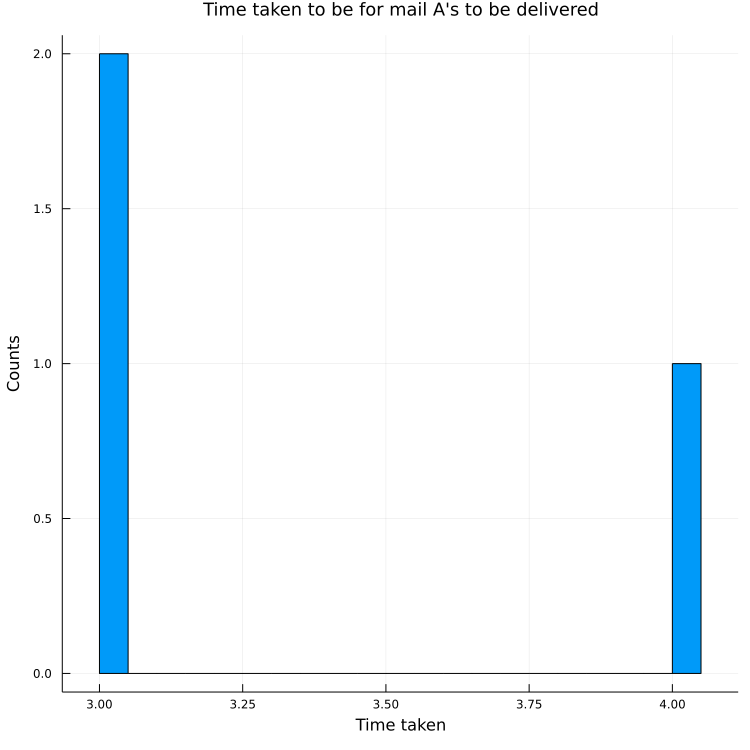

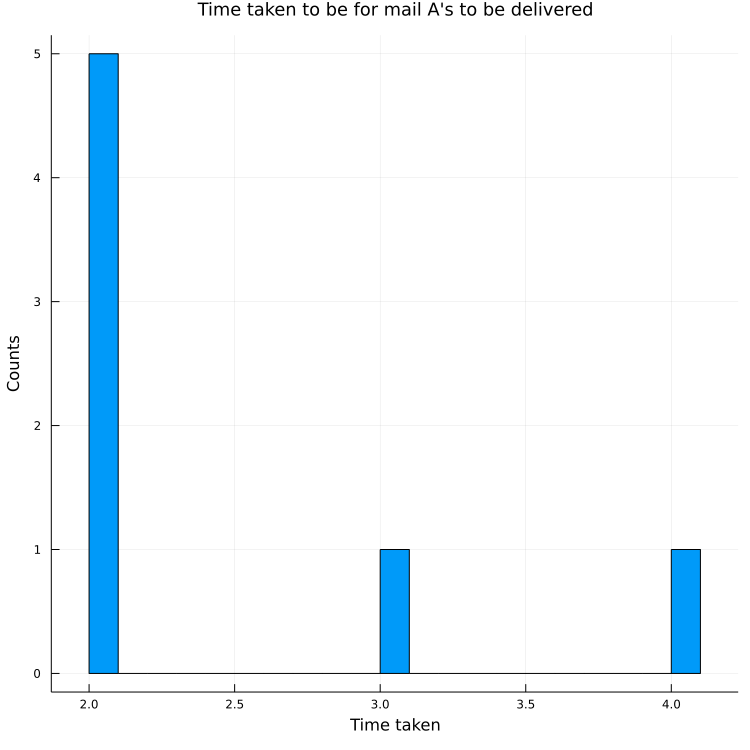

3-element Vector{Int16}:
 3
 3
 4

7-element Vector{Int16}:
 2
 2
 2
 2
 2
 3
 4

In [127]:
time_diff_A, time_diff_B = time_start_end(H,40,40); 
display(time_diff_A)
display(time_diff_B)


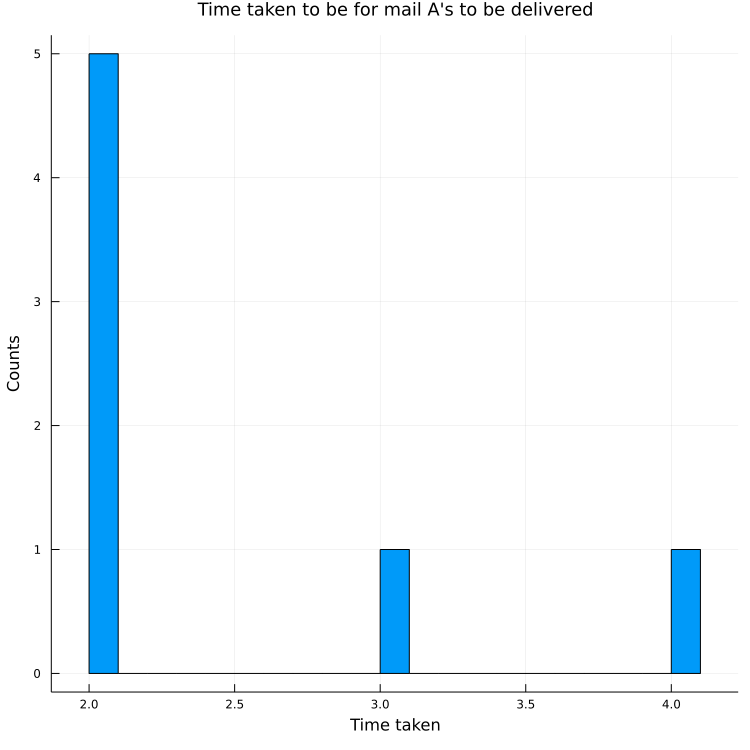

In [121]:
display(histogram(time_diff_B, nbins=20, title = "Time taken to be for mail A's to be delivered", 
            xlabel = "Time taken", ylabel = "Counts",legend=false,titlefontsize=12)) 

## Plot animation

In [23]:
function plotMapFromConnectivity(C,nCol,nRow;hotspot=nothing)
    # C is the connectivity matrix
    # nCol is the number of columns
    # nRow is the number of rows
    # hotspot, a keyword argument, is the congested spot which default to nothing
    
    # rectrangular patch
    rect(w, h, x, y) = Shape(x .+ [0,w,w,0], y .+ [0,0,h,h])
    # convert 1D to 2D index
    getXY= (x) -> ((x.-1) .% nCol .+ 1,(x.-1) .÷ nCol .+ 1 ) ;
    
    plot(xlim=(0,nCol), xticks=[0:nCol;],ylim=(0,nRow),yticks=[0:nRow;],
        legend=false,aspect_ratio=:equal,framestyle=:box,
        grid=true,foreground_color_grid=:black,gridalpha=1,gridlinewidth=1)
    
#     unreachable cells: black
    s=dropdims(sum(C[1:end-1,2:end-1],dims=1),dims=1)
    for i in findall(x->x==0,s)
        x,y=getXY(i)
        plot!(rect(1,1,x-1,y-1),color=:black)
    end
    
#     entry sites: transparent green
    entries=findall(x->x==1,C[1,:])
    for i in entries
        x,y=getXY(i-1)
        plot!(rect(1,1,x-1,y-1),color=:green,opacity=0.2,
            annotation = [(x-0.5, y-0.2, "entry")],annotationfontsize=8)
    end   
    
#     exit sites: transparent red
    exits=findall(x->x==1,C[2:end-1,end])
    for i in exits
        x,y=getXY(i)
        plot!(rect(1,1,x-1,y-1),color=:red,opacity=0.2,
            annotation = [(x-0.5, y-0.8, "exit")],annotationfontsize=8)
    end

#  connected site: arrow   
    s=dropdims(sum(C[2:end-1,2:end-1],dims=2),dims=2)    
    for r in findall(x->x>0,s)
        reachable=findall(x->x==1,C[r+1,2:end-1])
        x0,y0=getXY(r) 
        x1,y1=getXY(reachable)
        dx,dy=x1.-x0,y1.-y0;
        quiver!([x0-0.5].+0.25.*dx,[y0-0.5].+0.25.*dy,
                quiver=((dx.*0.5,dy.*0.5)),color=:black)
    end
    
#  hotspot: dotted outline
    if !isnothing(hotspot)
        for i in hotspot
            x,y=getXY(i)
            plot!([x-1,x-1,x,x,x-1],[y-1,y,y,y-1,y-1],color=:red,linewidth=3,linestyle=:dot)
        end
    end
    return current()
end

plotMapFromConnectivity (generic function with 1 method)

In [24]:
function plotAllCarAtOneInstant2(H,t,nCol,nRow;c=palette(:tab10))
    # H is the history matrix
    # t is time step
    # nCol is the number of columns
    # nRow is the number of rows
    # c, a keyword argument, is the color palette which default to tab10
    pos=H[:,t];
    maxNodes=nCol*nRow;
    getXY= (x) -> ((x.-1) .% nCol .+ 1,(x.-1) .÷ nCol .+ 1 ) ;    
    
    id=findall(x->x>0 && x<=maxNodes,pos);
    x,y=getXY(pos[id]);
    annot=[(xx-0.5,yy-0.5,"$(i)") for (i,xx,yy) in zip(id,x,y)];
    shape=[:circle for i in id];
    (t>1) && (shape[H[id,t-1].==0].=:diamond);
    
    return scatter!(x.-0.5,y.-0.5,color=c[(id.-1).%length(c).+1],
                    title="t=$(t-1)",
                    annotation = annot, annotationfontsize=9,
                    markershape=shape, markersize=16, markerstrokewidth=2)
end

plotAllCarAtOneInstant2 (generic function with 1 method)

In [25]:
function congest_plot2(H,a,b,L)
    ## H is the history matrix
    # a is the starting time chosen to check congestion
    # b is the final time
    # L is the number of sites
    
    counter=zeros(Int64,L) # the histogram 
    
    # use run length encoding to count
    for row in eachrow(H[:,a:b])
        p=filter(x-> x>0 && x<=L,row)
        for (k,l) in zip(rle(p)...) # run length encoding
            counter[k]+= l-1 #do not count the first occurence
        end
    end    
    
    # implementation 2: only traverse H once
#     for row in eachrow(H[:,a:b])
#         iter = Iterators.filter(x-> x>0 && x<=L,row)
#         (item1, state) = iterate(iter)
#         while (iter2=iterate(iter, state)) != nothing
#             (item2, state) = iter2        
#             item1==item2 && (counter[item1]+=1)
#             item1=item2
#         end
#     end
    
    x_point=findall(x->x==maximum(counter),counter)
    
    display(bar(counter,bar_edges=true,bar_width=1,xticks=[1:L;],
                title = "Congestion plot from time t=$a to t=$b", 
                xlabel = "Position", ylabel = "Number of cars halted",
                legend=false,titlefontsize=12))
        
    println("The maximum congetsion is at position $x_point during the time t=$a to t=$b")
    return x_point
end

congest_plot2 (generic function with 1 method)

In [26]:
NMail = 10; # number of mails
tM = 35; # total time steps
L = 6; # number of sites
numA = 3 # mail A number
numB = NMail - numA # mail B number

C = connect_matrix_2D();
conn_matA = connect_matrix_A()
conn_matB = connect_matrix_B()
H = initialize_H(NMail,tM);
for it = 1:tM+1
    H = next_step_k(H,it,C,L,numA,conn_matA,conn_matB);
end

nCol = 3;
nRow = 2;
gr(size=(750,750))
anim = Animation()
p4=plotMapFromConnectivity(C,nCol,nRow);
# p4=plotMapFromConnectivity(C,nCol,nRow;hotspot=ct4);
for t=1:tM+2-sum(sum(H.==nCol*nRow+1,dims=1).==L)
    plot(deepcopy(p4))
    plotAllCarAtOneInstant2(H,t,nCol,nRow;c=palette(:tab20))
    frame(anim)
end

┌ Info: Saved animation to 
│   fn = C:\Users\dario\Singapore University of Technology and Design\Chua Xue Li - SHARP\SHARP_Presentation_Activity\Delivery\simulation.gif
└ @ Plots C:\Users\dario\.julia\packages\Plots\zd6zi\src\animation.jl:104


Plots.AnimatedGif("C:\\Users\\dario\\Singapore University of Technology and Design\\Chua Xue Li - SHARP\\SHARP_Presentation_Activity\\Delivery\\simulation.gif")
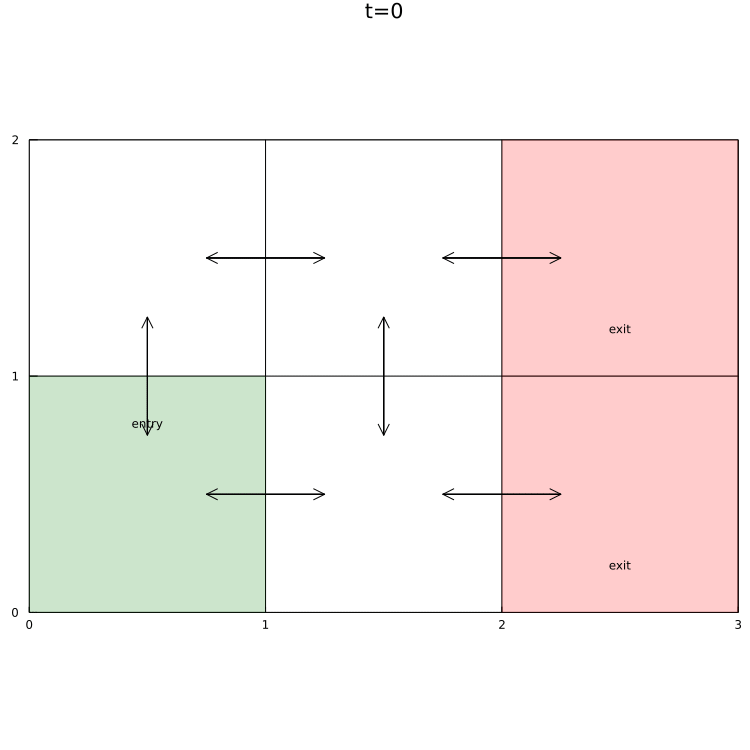

In [27]:
gif(anim,"simulation.gif",fps=1)

# shows smooth traffic
<img src="smoothtraffic.gif" width="750" align="center">

In [28]:
show(stdout, "text/plain", H)

10×37 Matrix{Int16}:
 0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  2  2  5  2  2  3  2  3  3  3  3  2  3  3  3  3  3  3  3  2  3  2
 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  1  2  2  5  5  5  5  5  4  5  4  4  4  4  4
 0  1  2  5  5  6  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7
 0  0  0  0  0  1  4  5  2  3  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7
 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  1  1  1  2  2  2  2  2  5  5  5  5
 0  0  0  0  0  0  0  0  0  0  0  0  1  2  3  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7
 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  1  1  1  4  4  4  4  4  4  4  4  4  1  1  1  1  1  1  1  1
 0  0  0  0  0  0  0  1  1  4  4  5  4  5  4  5  4  4  4  5  5  5  6  5  6  6  6  6  6  6  6  6  6  6  6  6  6
 0  0  0  0  0  0  0  0  0  0  1  2  3  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  7  

# shows blockade
<img src="blockade.gif" width="750" align="center">